<a href="https://colab.research.google.com/github/davidsherman96/mids_capstone_spring24_chang_li_sherman/blob/main/MONTH_multiple_county_CA_drought_random_forest_multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
import tensorflow as tf
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [4]:
# Set random seed for TensorFlow
tf.random.set_seed(123)

# Set random seed for Python
np.random.seed(123)

In [5]:
tf.keras.utils.set_random_seed(1)

tf.config.experimental.enable_op_determinism()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
data_all_county = pd.read_csv('/content/drive/MyDrive/CA_data_lat_log_weekly.csv')

In [8]:
data_all_county['date'] = pd.to_datetime(data_all_county['date'])
data_all_county['month'] = data_all_county['date'].dt.month

Define helper functions

In [9]:
def ts_multi_data_prep(dataset, target, start, end, window, step_out):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - step_out
        #end = len(dataset)
    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i, i+step_out) #revise the window definition
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [10]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print('Evaluation metric results:-')
    mse = metrics.mean_squared_error(y_true.flatten(), y_pred.flatten())
    mae = metrics.mean_absolute_error(y_true.flatten(), y_pred.flatten())
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(y_true.flatten(), y_pred.flatten())
    print(f'MSE is : {mse}')
    print(f'MAE is : {mae}')
    print(f'RMSE is : {rmse}')
    #print(f'MAPE is : {mape}')
    print(f'R2 is : {r2}\n')

In [11]:
def timeseries_evaluation_metrics_binary(y_true, y_pred):
    print('Evaluation metric results:-')
    accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
    precision = precision_score(y_true.flatten(), y_pred.flatten(), average='macro')
    recall = recall_score(y_true.flatten(), y_pred.flatten(), average='macro')
    f1 = f1_score(y_true.flatten(), y_pred.flatten(), average='macro')

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-score: {f1}\n')

In [12]:
hist_window = 30
step_out = 12
x_train_c, y_train_c, x_vali_c, y_vali_c, x_test_c, y_test_c = [], [], [], [], [], []
unique_fips = data_all_county['fips'].unique()
unique_fips_count = data_all_county['fips'].nunique()

for fips in unique_fips:
    # Extract dataframe for the current FIPS value
    data_county = data_all_county[data_all_county['fips'] == fips]

    X_data = data_county[['lat','lon','PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET',
       'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX',
       'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN',
       'WS50M_RANGE', 'score', 'month']]
 
    Y_data = data_county[['score']]
    
    #train_val_test split 70%-10%-20%
    n = len(X_data)
    x_train_county = X_data[0:int(n*0.7)]
    y_train_county = Y_data[0:int(n*0.7)]
    x_vali_county = X_data[int(n*0.7):int(n*0.8)]
    y_vali_county = Y_data[int(n*0.7):int(n*0.8)]
    x_test_county = X_data[int(n*0.8):]
    y_test_county = Y_data[int(n*0.8):]


    if fips == 6001:
        x_train_c, y_train_c, x_vali_c, y_vali_c, x_test_c, y_test_c = x_train_county, y_train_county, x_vali_county, y_vali_county, x_test_county, y_test_county

    else:
        x_train_c = np.concatenate((x_train_c, x_train_county), axis=0)
        y_train_c = np.concatenate((y_train_c, y_train_county), axis=0)
        x_vali_c = np.concatenate((x_vali_c, x_vali_county), axis=0)
        y_vali_c = np.concatenate((y_vali_c, y_vali_county), axis=0)
        x_test_c = np.concatenate((x_test_c, x_test_county), axis=0)
        y_test_c = np.concatenate((y_test_c, y_test_county), axis=0)

In [13]:
X_scaler_train = MinMaxScaler()
Y_scaler_train = MinMaxScaler()
X_scaler_test = MinMaxScaler()
Y_scaler_test = MinMaxScaler()
X_scaler_vali = MinMaxScaler()
Y_scaler_vali = MinMaxScaler()
x_train_data = X_scaler_train.fit_transform(x_train_c)
y_train_data = Y_scaler_train.fit_transform(y_train_c)
x_vali_data = X_scaler_vali.fit_transform(x_vali_c)
y_vali_data = Y_scaler_vali.fit_transform(y_vali_c)
x_test_data = X_scaler_test.fit_transform(x_test_c)
y_test_data = Y_scaler_test.fit_transform(y_test_c)

In [14]:
x_train_data.shape

(44486, 22)

In [15]:
def transform_county_data(x_data_array, y_data_array):
    # Lists to store x_train_c and y_train_c arrays
    x_c_list = []
    y_c_list = []
    # Divide the arrays into 'unique_fips_count' number of subarrays
    x_subarrays = np.array_split(x_data_array, unique_fips_count, axis=0)
    y_subarrays = np.array_split(y_data_array, unique_fips_count, axis=0)

    # Combine x_subarrays and y_subarrays into tuples
    data_tuples = [(x_subarray, y_subarray) for x_subarray, y_subarray in zip(x_subarrays, y_subarrays)]

    # Print or use the data tuples as needed
    for idx, data_tuple in enumerate(data_tuples):
        x_window_c, y_window_c = ts_multi_data_prep(data_tuple[0],data_tuple[1], 0, None, hist_window, step_out)
        # Append x_window_c and y_window_c arrays to lists
        x_c_list.append(x_window_c)
        y_c_list.append(y_window_c)

    # Stack arrays in lists to create x_train_c and y_train_c
    x_all_county = np.vstack(x_c_list)
    y_all_county = np.vstack(y_c_list)

    return x_all_county, y_all_county

In [16]:
x_train, y_train = transform_county_data(x_train_data, y_train_data)
x_vali, y_vali = transform_county_data(x_vali_data, y_vali_data)
x_test, y_test = transform_county_data(x_test_data, y_test_data)

In [19]:
# Convert all the 3D arrays to 2D for Random Forest
train_len = len(x_train)
num_features = X_data.shape[1]
vali_len = len(x_vali)
test_len = len(x_test)

# Reshape the labels into a simple 2D array
y_train = y_train.reshape(train_len, step_out)
y_vali = y_vali.reshape(vali_len, step_out)
y_test = y_test.reshape(test_len, step_out)

# Reshape the x data into a 2D array of (num windows, window size x features size)
x_train = x_train.reshape(train_len, hist_window * num_features)
x_vali = x_vali.reshape(vali_len, hist_window * num_features)
x_test = x_test.reshape(test_len, hist_window * num_features)

# Model

In [21]:
# Define RandomForestRegressor parameters
n_estimators = 300
max_depth = 4 
random_state = 42 

In [22]:
def random_forest_forecast(x_train, y_train, x_test):
    # fit the model
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    model.fit(x_train, y_train)

    feature_imp = model.feature_importances_

    # predict
    yhat = model.predict(x_test)
    return yhat, feature_imp

In [23]:
y_vali_pred, vali_feature_imp = random_forest_forecast(x_train, y_train, x_vali)

In [24]:
y_test_pred, feature_imp = random_forest_forecast(x_train, y_train, x_test)

# Model Evaluation

## Validation

In [57]:
# Apply inverse transform
y_vali_pred_Inverse = Y_scaler_vali.inverse_transform(y_vali_pred)
y_vali_pred_Inverse_ordinal = np.round(y_vali_pred_Inverse).astype(int)
y_vali_Inverse = Y_scaler_vali.inverse_transform(y_vali)
y_vali_Inverse_ordinal = np.round(y_vali_Inverse).astype(int)

In [58]:
timeseries_evaluation_metrics_func(y_vali_Inverse,y_vali_pred_Inverse)

Evaluation metric results:-
MSE is : 0.24369590494404686
MAE is : 0.3197751672122448
RMSE is : 0.49365565422067925
R2 is : 0.8355279401922858



In [59]:
timeseries_evaluation_metrics_func(y_vali_Inverse_ordinal,y_vali_pred_Inverse_ordinal)

Evaluation metric results:-
MSE is : 0.38085434894493053
MAE is : 0.318793961228341
RMSE is : 0.617133979736111
R2 is : 0.763382435159917



Text(0.5, 1.0, 'Distribution of Actual Validation Drought Scores')

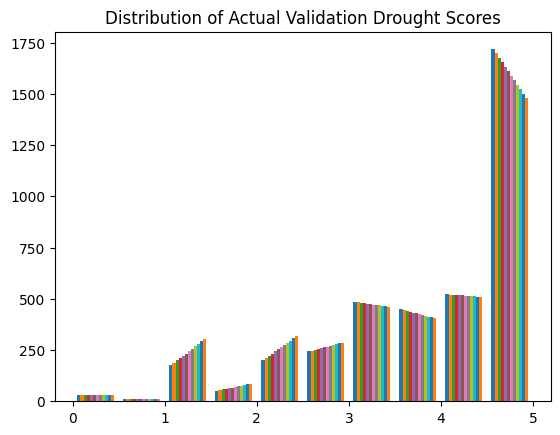

In [60]:
plt.hist(y_vali_Inverse)
plt.title('Distribution of Actual Validation Drought Scores')

Text(0.5, 1.0, 'Distribution of Predicted Validation Drought Scores')

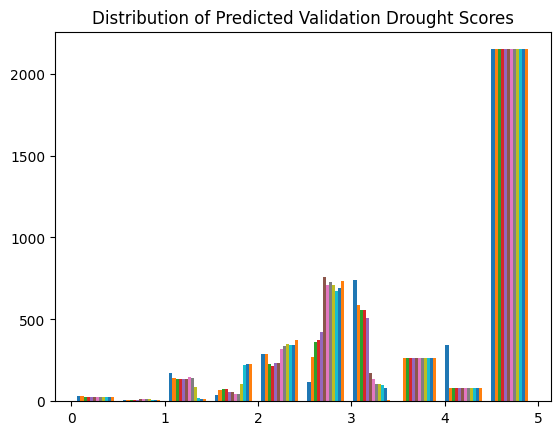

In [61]:
plt.hist(y_vali_pred_Inverse)
plt.title('Distribution of Predicted Validation Drought Scores')

## Test

In [62]:
# Apply inverse transform
y_test_pred_Inverse = Y_scaler_test.inverse_transform(y_test_pred)
y_test_pred_Inverse_ordinal = np.round(y_test_pred_Inverse).astype(int)
y_test_Inverse = Y_scaler_test.inverse_transform(y_test)
y_test_Inverse_ordinal = np.round(y_test_Inverse).astype(int)

In [63]:
timeseries_evaluation_metrics_func(y_test_Inverse,y_test_pred_Inverse)

Evaluation metric results:-
MSE is : 0.3150855507718481
MAE is : 0.36728775528048724
RMSE is : 0.5613248175271143
R2 is : 0.7079805972540019



In [64]:
timeseries_evaluation_metrics_func(y_test_Inverse_ordinal,y_test_pred_Inverse_ordinal)

Evaluation metric results:-
MSE is : 0.42335012269146327
MAE is : 0.3342212320805889
RMSE is : 0.6506536119099495
R2 is : 0.6316776616977531



Text(0.5, 1.0, 'Distribution of Actual Test Drought Scores')

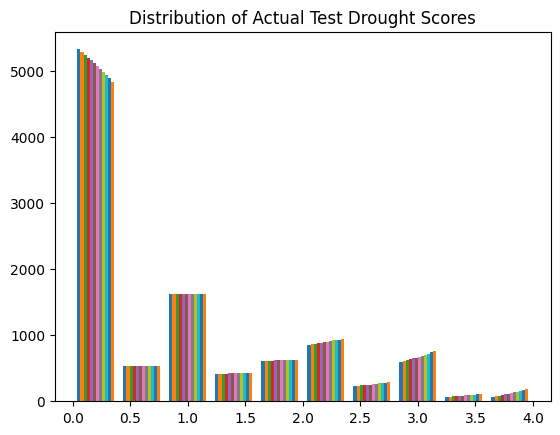

In [65]:
plt.hist(y_test_Inverse)
plt.title('Distribution of Actual Test Drought Scores')

Text(0.5, 1.0, 'Distribution of Predicted Test Drought Scores')

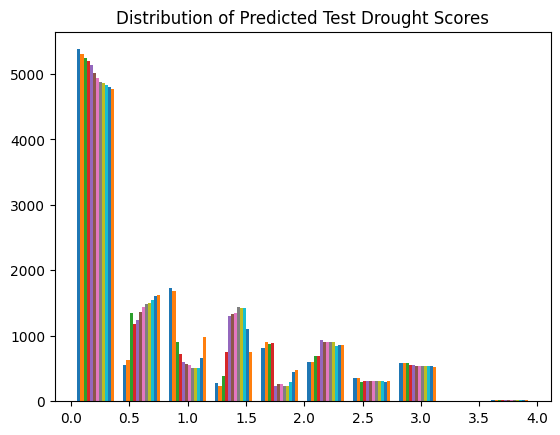

In [66]:
plt.hist(y_test_pred_Inverse)
plt.title('Distribution of Predicted Test Drought Scores')

## Binary Classification Evaluation

### Using 2.5 as "Severe" Drought Classification:

In [67]:
threshold = 2.5
y_test_Inverse_binary = np.where(y_test_Inverse >= threshold, 1, 0)
y_test_pred_Inverse_binary = np.where(y_test_pred_Inverse >= threshold, 1, 0)

In [68]:
timeseries_evaluation_metrics_binary(y_test_Inverse_binary,y_test_pred_Inverse_binary)

Evaluation metric results:-
Accuracy: 0.9551449696500065
Precision: 0.936767854820753
Recall: 0.8139876491598241
F1-score: 0.8625528951740955



In [69]:
# Compute classification report
classification_metrics = classification_report(y_test_Inverse_binary.flatten(),y_test_pred_Inverse_binary.flatten())

# Print classification report
print(classification_metrics)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98    110778
           1       0.92      0.63      0.75     13110

    accuracy                           0.96    123888
   macro avg       0.94      0.81      0.86    123888
weighted avg       0.95      0.96      0.95    123888



Confusion Matrix:
[[110007    771]
 [  4786   8324]]


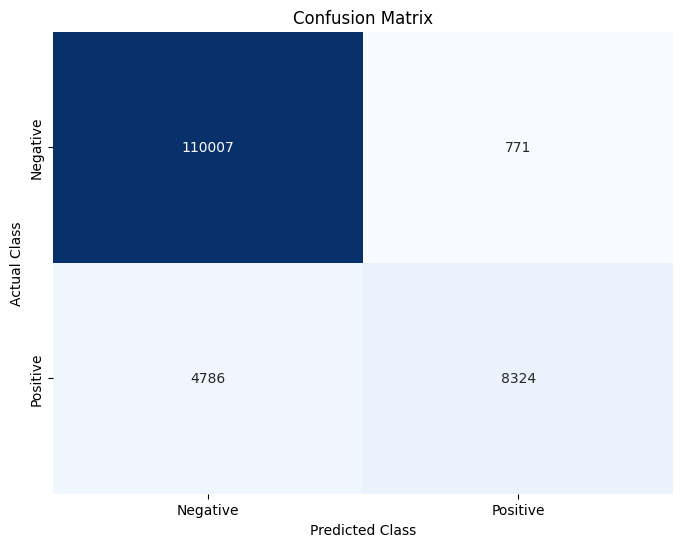

In [70]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_Inverse_binary.flatten(), y_test_pred_Inverse_binary.flatten())

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

### Using 1.5 as "Moderate" Score

A score of 2 is considered Moderate drought. A score of 1.5 would be rounded up to 2.

In [71]:
threshold = 1.5
y_test_Inverse_binary = np.where(y_test_Inverse >= threshold, 1, 0)
y_test_pred_Inverse_binary = np.where(y_test_pred_Inverse >= threshold, 1, 0)

In [72]:
timeseries_evaluation_metrics_binary(y_test_Inverse_binary,y_test_pred_Inverse_binary)

Evaluation metric results:-
Accuracy: 0.8950503680743898
Precision: 0.8780765997760276
Recall: 0.847285856131318
F1-score: 0.8608397221396078



In [73]:
# Compute classification report
classification_metrics = classification_report(y_test_Inverse_binary.flatten(),y_test_pred_Inverse_binary.flatten())
#classification_metrics = classification_report(y_test_Inverse_ordinal.flatten(),y_test_pred_Inverse_ordinal.flatten())
# Print classification report
print(classification_metrics)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     90660
           1       0.85      0.74      0.79     33228

    accuracy                           0.90    123888
   macro avg       0.88      0.85      0.86    123888
weighted avg       0.89      0.90      0.89    123888



Confusion Matrix:
[[86156  4504]
 [ 8498 24730]]


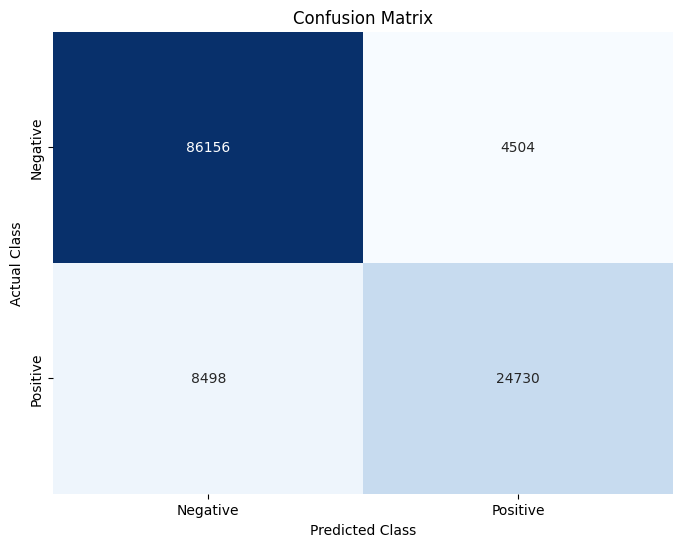

In [74]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_Inverse_binary.flatten(), y_test_pred_Inverse_binary.flatten())

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

### Using 0.5 as "Any Drought" Score

A score of 1 is considered abnormally dry. A score of 0.5 would be rounded up to 1:


In [75]:
threshold = 0.5
y_test_Inverse_binary = np.where(y_test_Inverse >= threshold, 1, 0)
y_test_pred_Inverse_binary = np.where(y_test_pred_Inverse >= threshold, 1, 0)

In [76]:
timeseries_evaluation_metrics_binary(y_test_Inverse_binary,y_test_pred_Inverse_binary)

Evaluation metric results:-
Accuracy: 0.8294911532997546
Precision: 0.8300740801524112
Recall: 0.8291603460820083
F1-score: 0.8292858766676825



In [77]:
# Compute classification report
classification_metrics = classification_report(y_test_Inverse_binary.flatten(),y_test_pred_Inverse_binary.flatten())

# Print classification report
print(classification_metrics)

              precision    recall  f1-score   support

           0       0.82      0.85      0.84     62856
           1       0.84      0.81      0.82     61032

    accuracy                           0.83    123888
   macro avg       0.83      0.83      0.83    123888
weighted avg       0.83      0.83      0.83    123888



Confusion Matrix:
[[53530  9326]
 [11798 49234]]


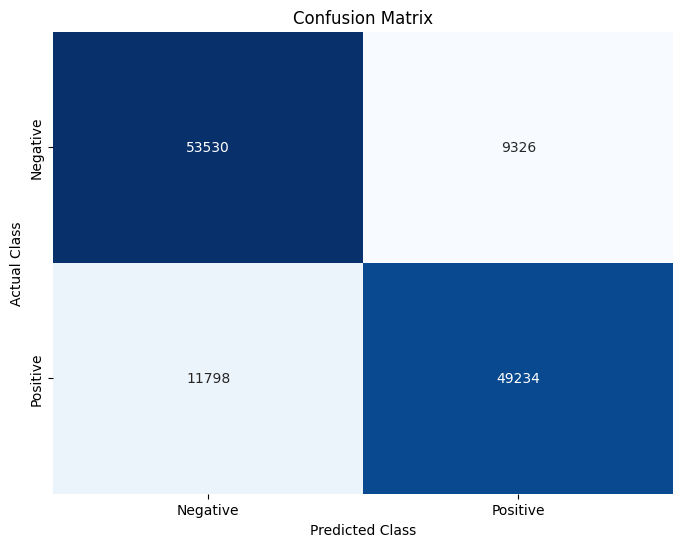

In [78]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_Inverse_binary.flatten(), y_test_pred_Inverse_binary.flatten())

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

### Using Extreme Drought as Threshold - 3.5

Extreme Drought is a score of 4. Scores at 3.5 or higher will round up to 4.

In [79]:
threshold = 3.5
y_test_Inverse_binary = np.where(y_test_Inverse >= threshold, 1, 0)
y_test_pred_Inverse_binary = np.where(y_test_pred_Inverse >= threshold, 1, 0)

In [80]:
timeseries_evaluation_metrics_binary(y_test_Inverse_binary,y_test_pred_Inverse_binary)

Evaluation metric results:-
Accuracy: 0.9860761332816738
Precision: 0.7703552411553543
Recall: 0.5319686359839537
F1-score: 0.554410422377643



In [81]:
# Compute classification report
classification_metrics = classification_report(y_test_Inverse_binary.flatten(),y_test_pred_Inverse_binary.flatten())

# Print classification report
print(classification_metrics)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    122141
           1       0.55      0.06      0.12      1747

    accuracy                           0.99    123888
   macro avg       0.77      0.53      0.55    123888
weighted avg       0.98      0.99      0.98    123888



Confusion Matrix:
[[122050     91]
 [  1634    113]]


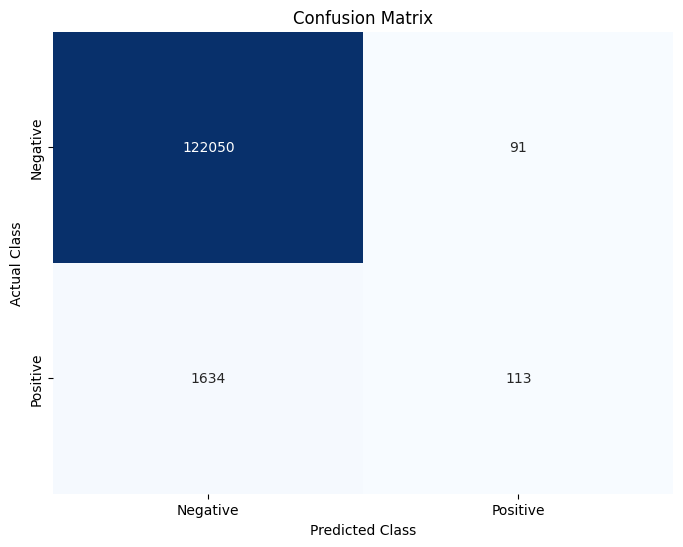

In [82]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_Inverse_binary.flatten(), y_test_pred_Inverse_binary.flatten())

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

# Feature Importance

In [83]:
feature_imp

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.42332097e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.27441739e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [84]:
feature_imp.shape

(660,)

In [86]:
feature_imp.shape[0] / num_features

30.0

In [87]:
def get_features_sum(num_windows, num_features, features_ar):
    features_ar = np.reshape(features_ar, [num_windows, num_features])

    feature_df = pd.DataFrame(data = features_ar,
                      columns = ['lat','lon','PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET',
       'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX',
       'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN',
       'WS50M_RANGE', 'score', 'month'])

    print(feature_df.sum())
    # print(feature_df.sum().apply(lambda x: format(x, '.20f')))

In [88]:
get_features_sum(int(feature_imp.shape[0] / num_features), num_features, feature_imp)

lat            0.000000e+00
lon            0.000000e+00
PRECTOT        1.795317e-03
PS             4.411850e-06
QV2M           2.621271e-03
T2M            1.336561e-06
T2MDEW         0.000000e+00
T2MWET         1.062340e-06
T2M_MAX        2.759988e-06
T2M_MIN        0.000000e+00
T2M_RANGE      0.000000e+00
TS             1.530375e-06
WS10M          0.000000e+00
WS10M_MAX      0.000000e+00
WS10M_MIN      2.790106e-06
WS10M_RANGE    0.000000e+00
WS50M          0.000000e+00
WS50M_MAX      0.000000e+00
WS50M_MIN      9.848225e-07
WS50M_RANGE    0.000000e+00
score          9.691055e-01
month          2.646299e-02
dtype: float64
